# 1. NiN网络

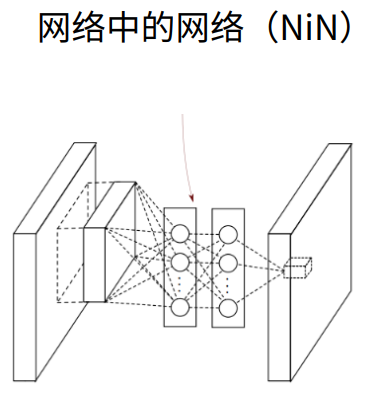

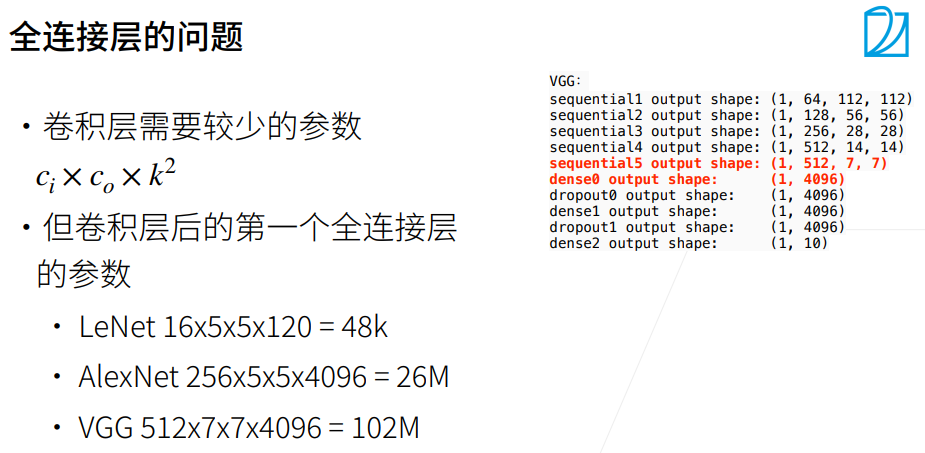

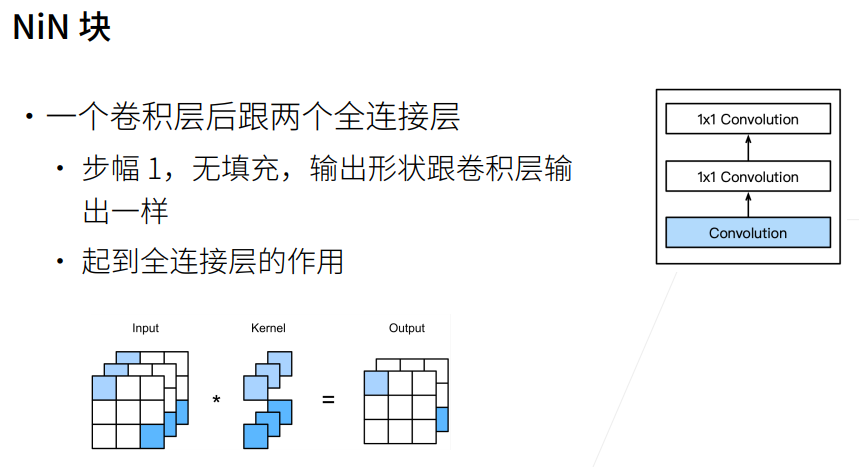

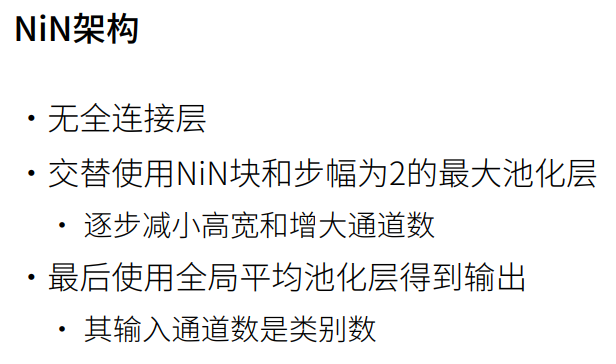

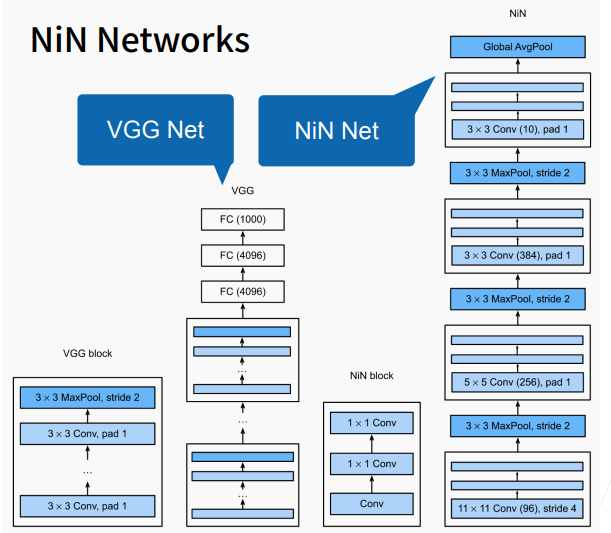

# 2. 总结

① 在全局平均池化层（GAP）被提出之前，常用的方式是将feature map直接拉平成一维向量，但是GAP不同，是将每个通道的二维图像做平均，最后也就是每个通道对应一个均值。

②  假设卷积层的最后输出是h × w × d 的三维特征图，具体大小为6 × 6 × 3，经过GAP转换后，变成了大小为 1 × 1 × 3 的输出值，也就是每一层 h × w 会被平均化成一个值，如下图所示。

③ GPA优势：

1. 抑制过拟合。直接拉平做全连接层的方式依然保留了大量的空间信息，假设feature map是32个通道的10 * 10图像，那么拉平就得到了32 * 10 * 10的向量，如果是最后一层是对应两类标签，那么这一层就需要3200 * 2的权重矩阵，而GAP不同，将空间上的信息直接用均值代替，32个通道GAP之后得到的向量都是32的向量，那么最后一层只需要32 * 2的权重矩阵。相比之下GAP网络参数会更少，而全连接更容易在大量保留下来的空间信息上面过拟合。

2. 输入尺寸更加灵活。在第1点的举例里面可以看到feature map经过GAP后的神经网络参数不再与输入图像尺寸的大小有关，也就是输入图像的长宽可以不固定。

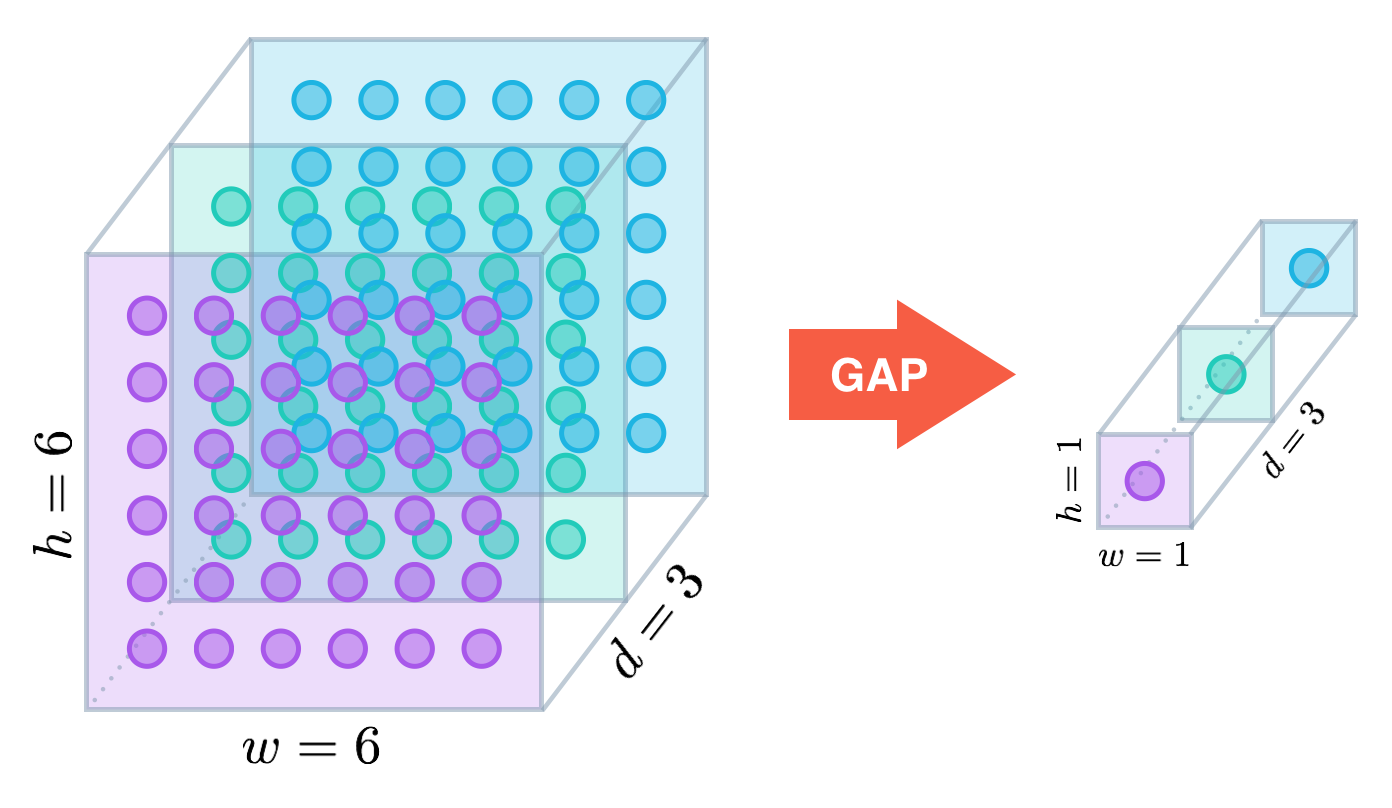

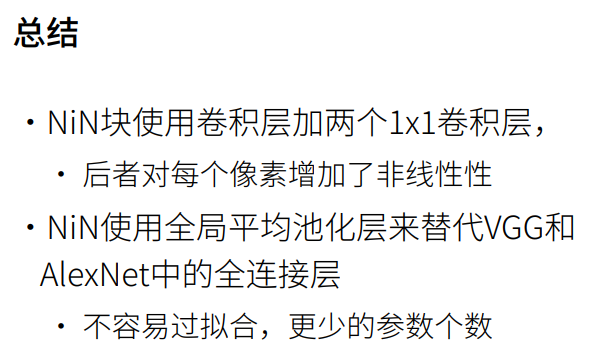

# 1. NiN网络（使用自定义）

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, strides,padding),
                         nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
                         nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
                         nn.ReLU())    

net = nn.Sequential(nin_block(1,96,kernel_size=11,strides=4,padding=0),
                   nn.MaxPool2d(3,stride=2),
                   nin_block(96,256,kernel_size=5,strides=1,padding=2),
                   nn.MaxPool2d(3,stride=2),
                   nin_block(256,384,kernel_size=3,strides=1,padding=1),
                   nn.MaxPool2d(3,stride=2),nn.Dropout(0.5),
                   nin_block(384,10,kernel_size=3,strides=1,padding=1),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

# 查看每个块的输出形状
X = torch.rand(size=(1,1,224,224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.341, train acc 0.874, test acc 0.834
1627.8 examples/sec on cuda:0


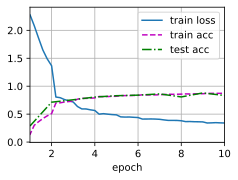

In [2]:
# 训练模型
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)    
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())